
Benchmarking: sine_mix

--- Running ML-II ---
ML-II completed in 0.92s

--- Running MAP-II ---
MAP-II completed in 0.64s

--- Running SMC-VFE ---
SMC-VFE completed in 1.43s

Predicting...

Test Metrics:
  ML-II  | RMSE: 0.627 | NLPD: 7.262 | Cov: 36.67
  MAP-II | RMSE: 0.627 | NLPD: 7.262 | Cov: 36.67
  SMC    | RMSE: 0.720 | NLPD: 6.037 | Cov: 46.67


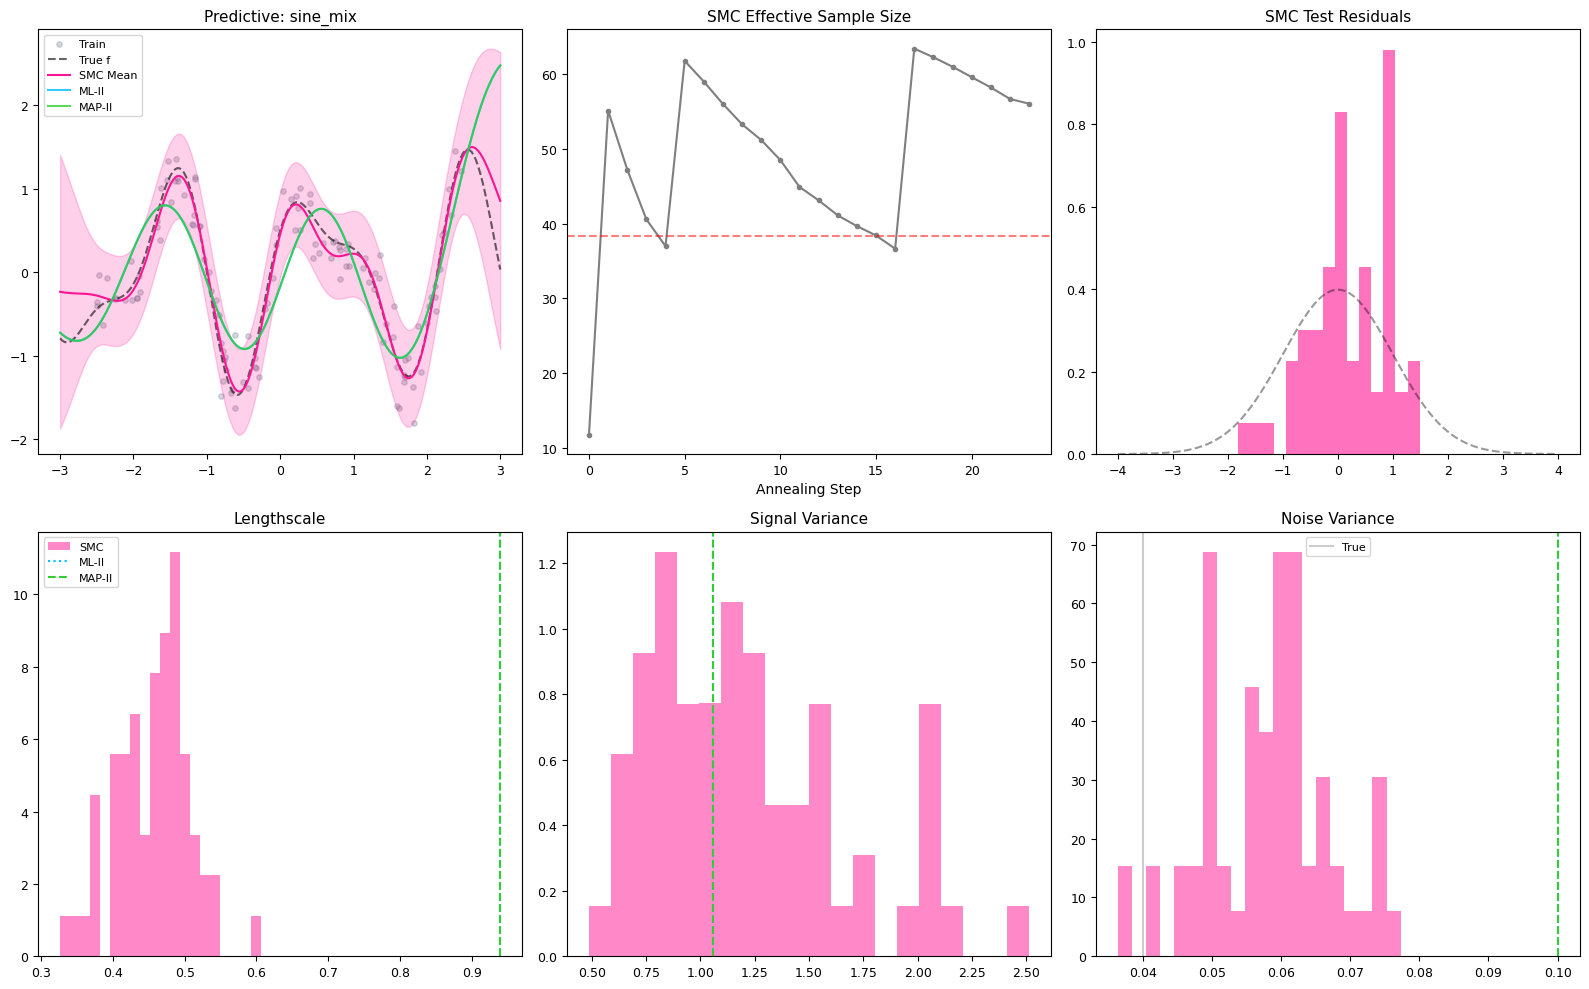

In [ ]:
#!/usr/bin/env python
# coding: utf-8

import os
import sys
import time
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, List, Callable, Tuple

# Force CPU execution for stability with JAX Metal on macOS
os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["JAX_ENABLE_X64"] = "True"

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Ensure repository root is in path
repo_root = Path(os.getcwd())
while repo_root.parent != repo_root:
    if (repo_root / 'infodynamics_jax').exists():
        break
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from infodynamics_jax.core import Phi
from infodynamics_jax.gp.kernels import rbf
from infodynamics_jax.gp.kernels.params import KernelParams
from infodynamics_jax.gp.likelihoods import get as get_likelihood
from infodynamics_jax.gp.predict import predict_typeii
from infodynamics_jax.gp.sparsify import fitc_log_evidence
from infodynamics_jax.inference.optimisation import TypeII, TypeIICFG
from infodynamics_jax.inference.optimisation.vfe import make_vfe_objective
from infodynamics_jax.infodynamics import make_hyperprior
from utils import synthetic, compute_metrics, setup_plot_style, plot_with_uncertainty
from utils.smc_array_only import annealed_smc_array

# Initialize plotting style
setup_plot_style()
matplotlib.use('module://matplotlib_inline.backend_inline')

# Local color scheme to match stylized benchmarks
COLORS = {
    'smc': '#FF1493',  # Deep Pink
    'ml': '#00BFFF',   # Deep Sky Blue
    'map': '#32CD32',  # Lime Green
    'true': '#000000', # Black
    'train': '#708090',# Slate Gray
    'test': '#FF4500'  # Orange Red
}

@dataclass
class CFG:
    # Data params
    N_train: int = 120
    N_test: int = 60
    noise_std: float = 0.2
    domain: tuple = (-2.5, 2.5)
    
    # Sparse GP params
    M: int = 20
    jitter: float = 1e-6
    
    # SMC params
    n_particles: int = 64
    n_steps: int = 24
    ess_threshold: float = 0.6
    rejuvenation_steps: int = 2
    step_size: float = 0.02
    n_leapfrog: int = 8
    
    # Type-II Optimisation params
    typeii_steps: int = 300
    typeii_lr: float = 1e-2

cfg = CFG()

def unpack_state(theta: jnp.ndarray, shape_z: Tuple[int, int]):
    log_ell = theta[0]
    log_sf2 = theta[1]
    log_sn2 = theta[2]
    Z = theta[3:].reshape(shape_z)
    return log_ell, log_sf2, log_sn2, Z

def get_energy_fn(X, y, hyperprior_fn, shape_z, jitter):
    def energy_theta(theta):
        log_ell, log_sf2, log_sn2, Z = unpack_state(theta, shape_z)
        params = KernelParams(lengthscale=jnp.exp(log_ell), variance=jnp.exp(log_sf2))
        noise_var = jnp.exp(log_sn2)
        E_fitc = -fitc_log_evidence(kernel_fn=rbf, params=params, X=X, y=y, Z=Z, noise_var=noise_var, jitter=jitter)
        phi = Phi(kernel_params=params, Z=Z, likelihood_params={'noise_var': noise_var}, jitter=jitter)
        return E_fitc + hyperprior_fn(phi)
    return energy_theta

def run_benchmark(name: str):
    print(f"\n{'='*60}")
    print(f"Benchmarking: {name}")
    print(f"{'='*60}")
    
    key = jax.random.PRNGKey(42)
    key_data, key_smc, key_init = jax.random.split(key, 3)
    
    # 1. Data Generation
    fn, title, expr, _ = synthetic.get(name)
    X_all, Y_all, _ = synthetic.sample(name, N=cfg.N_train + cfg.N_test, noise=cfg.noise_std, domain=cfg.domain, key=key_data)
    X_all = X_all[:, None]
    
    perm = jax.random.permutation(key_data, X_all.shape[0])
    X_tr, Y_tr = X_all[perm[:cfg.N_train]], Y_all[perm[:cfg.N_train]]
    X_te, Y_te = X_all[perm[cfg.N_train:]], Y_all[perm[cfg.N_train:]]
    
    X_plot = jnp.linspace(cfg.domain[0]-0.5, cfg.domain[1]+0.5, 200)[:, None]
    y_true_plot = fn(X_plot[:, 0])

    # 2. Setup Prior
    hyperprior_fn = make_hyperprior(
        kernel_log_lambda=4.0, 
        kernel_fields=["lengthscale", "variance"], 
        likelihood_log_lambda=4.0, 
        likelihood_keys=["noise_var"], 
        likelihood_log_mu={'noise_var': jnp.log(cfg.noise_std**2)}
    )
    
    # Initial inducing points (even grid)
    Z0 = jnp.linspace(cfg.domain[0], cfg.domain[1], cfg.M)[:, None]
    phi_init = Phi(KernelParams(jnp.array(1.0), jnp.array(1.0)), Z0, {'noise_var': jnp.array(cfg.noise_std**2)}, cfg.jitter)

    # 3. Model Optimization (ML-II and MAP-II)
    print("\n--- Running ML-II ---")
    start_time = time.time()
    typeii = TypeII(cfg=TypeIICFG(steps=cfg.typeii_steps, lr=cfg.typeii_lr, optimizer='adam', jit=True))
    # ML-II: Optimize VFE objective (no hyperprior)
    # Objective: phi* = argmin_phi VFE(phi)
    # VFE = NLL(y; 0, Q + σ²I) + (1/(2σ²)) * tr(K_ff - Q_ff)
    vfe_obj = make_vfe_objective(kernel_fn=rbf, residual='fitc')
    
    phi_ml = typeii.run(energy=vfe_obj, phi_init=phi_init, energy_args=(X_tr, Y_tr)).phi
    ml_time = time.time() - start_time
    print(f"ML-II completed in {ml_time:.2f}s")
    
    print("\n--- Running MAP-II ---")
    start_time = time.time()
    # MAP-II: Optimize VFE + log hyperprior
    # Objective: phi* = argmin_phi [VFE(phi) + log p(phi)]
    # where hyperprior_fn(phi) returns -log p(phi) (penalty term)
    def map_obj(phi, x, y): return vfe_obj(phi, x, y) + hyperprior_fn(phi)
    phi_map = typeii.run(energy=map_obj, phi_init=phi_init, energy_args=(X_tr, Y_tr)).phi
    map_time = time.time() - start_time
    print(f"MAP-II completed in {map_time:.2f}s")

    # 4. SMC-VFE
    print("\n--- Running SMC-VFE ---")
    start_time = time.time()
    
    energy_fn = get_energy_fn(X_tr, Y_tr, hyperprior_fn, Z0.shape, cfg.jitter)
    
    def init_parts(k, n):
        kl, kv, kn, kz = jax.random.split(k, 4)
        log_l = jnp.log(phi_init.kernel_params.lengthscale) + jax.random.normal(kl, (n,)) * 0.5
        log_v = jnp.log(phi_init.kernel_params.variance) + jax.random.normal(kv, (n,)) * 0.5
        log_n = jnp.log(phi_init.likelihood_params['noise_var']) + jax.random.normal(kn, (n,)) * 0.5
        Z_noisy = Z0[None] + 0.2 * jax.random.normal(kz, (n, *Z0.shape))
        return jnp.concatenate([log_l[:,None], log_v[:,None], log_n[:,None], Z_noisy.reshape(n, -1)], axis=1)
    
    smc_res = annealed_smc_array(
        key=key_smc,
        init_particles=init_parts(key_init, cfg.n_particles),
        energy_fn=energy_fn,
        n_steps=cfg.n_steps,
        ess_threshold=cfg.ess_threshold,
        step_size=cfg.step_size,
        n_leapfrog=cfg.n_leapfrog,
        rejuvenation_steps=cfg.rejuvenation_steps
    )
    smc_time = time.time() - start_time
    print(f"SMC-VFE completed in {smc_time:.2f}s")

    # 5. Prediction
    print("\nPredicting...")
    # Point estimates
    y_pred_ml, y_var_ml = predict_typeii(phi_ml, X_plot, X_tr, Y_tr, rbf, residual='fitc')
    y_pred_map, y_var_map = predict_typeii(phi_map, X_plot, X_tr, Y_tr, rbf, residual='fitc')
    
    # SMC BMA
    def predict_bma(particles, logw, X_star, X_tr, Y_tr, shape_z, jitter):
        weights = jnp.exp(logw - jax.scipy.special.logsumexp(logw))
        mus, vars_ = [], []
        for i in range(len(weights)):
            ll, lv, ln, Z = unpack_state(particles[i], shape_z)
            phi_i = Phi(KernelParams(jnp.exp(ll), jnp.exp(lv)), Z, {'noise_var': jnp.exp(ln)}, jitter)
            m, v = predict_typeii(phi_i, X_star, X_tr, Y_tr, rbf, residual='fitc')
            mus.append(m); vars_.append(v)
        mus, vars_ = jnp.stack(mus), jnp.stack(vars_)
        mean_bma = (weights[:, None] * mus).sum(axis=0)
        var_bma = (weights[:, None] * (vars_ + mus**2)).sum(axis=0) - mean_bma**2
        return mean_bma, jnp.sqrt(jnp.maximum(var_bma, 1e-12)), mus, weights

    y_pred_smc, y_std_smc, _, _ = predict_bma(smc_res['particles'], smc_res['logw'], X_plot, X_tr, Y_tr, Z0.shape, cfg.jitter)

    # 6. Metrics on Test Set
    def print_metrics(m, v, y, label):
        metrics = compute_metrics(m, v, y)
        print(f"  {label:6} | RMSE: {metrics['rmse']:.3f} | NLPD: {metrics['nlpd']:.3f} | Cov: {metrics['coverage']:.2f}")

    print("\nTest Metrics:")
    y_p_ml_te, y_v_ml_te = predict_typeii(phi_ml, X_te, X_tr, Y_tr, rbf, residual='fitc')
    print_metrics(y_p_ml_te, y_v_ml_te, Y_te, "ML-II")
    
    y_p_map_te, y_v_map_te = predict_typeii(phi_map, X_te, X_tr, Y_tr, rbf, residual='fitc')
    print_metrics(y_p_map_te, y_v_map_te, Y_te, "MAP-II")
    
    y_p_smc_te, y_std_smc_te, _, _ = predict_bma(smc_res['particles'], smc_res['logw'], X_te, X_tr, Y_tr, Z0.shape, cfg.jitter)
    print_metrics(y_p_smc_te, y_std_smc_te**2, Y_te, "SMC")

    # 7. Plotting
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    ax_pred, ax_ess, ax_resid = axes[0]
    ax_ls, ax_sf2, ax_sn2 = axes[1]

    # Panel 1: Predictive
    ax_pred.scatter(X_tr, Y_tr, c=COLORS['train'], s=15, alpha=0.3, label='Train')
    ax_pred.plot(X_plot, y_true_plot, 'k--', alpha=0.6, label='True f')
    plot_with_uncertainty(ax_pred, X_plot, y_pred_smc, y_std_smc, color=COLORS['smc'], label_mean="SMC Mean")
    ax_pred.plot(X_plot, y_pred_ml, color=COLORS['ml'], label='ML-II', alpha=0.8)
    ax_pred.plot(X_plot, y_pred_map, color=COLORS['map'], label='MAP-II', alpha=0.8)
    ax_pred.set_title(f"Predictive: {name}")
    ax_pred.legend(fontsize=8)

    # Panel 2: ESS
    ax_ess.plot(smc_res['ess_trace'], color='C7', marker='.')
    ax_ess.axhline(cfg.ess_threshold * cfg.n_particles, ls='--', color='r', alpha=0.5)
    ax_ess.set_title("SMC Effective Sample Size")
    ax_ess.set_xlabel("Annealing Step")

    # Panel 3: Residuals
    resid_smc = (Y_te - y_p_smc_te) / y_std_smc_te
    ax_resid.hist(resid_smc, bins=15, density=True, alpha=0.6, color=COLORS['smc'])
    z = jnp.linspace(-4, 4, 100)
    ax_resid.plot(z, 1/jnp.sqrt(2*jnp.pi)*jnp.exp(-0.5*z**2), 'k--', alpha=0.4)
    ax_resid.set_title("SMC Test Residuals")

    # Hyperparams
    particles = smc_res['particles']
    ax_ls.hist(jnp.exp(particles[:, 0]), bins=20, density=True, alpha=0.5, color=COLORS['smc'], label="SMC")
    ax_ls.axvline(phi_ml.kernel_params.lengthscale, color=COLORS['ml'], ls=':', label="ML-II")
    ax_ls.axvline(phi_map.kernel_params.lengthscale, color=COLORS['map'], ls='--', label="MAP-II")
    ax_ls.set_title("Lengthscale")
    ax_ls.legend(fontsize=8)

    ax_sf2.hist(jnp.exp(particles[:, 1]), bins=20, density=True, alpha=0.5, color=COLORS['smc'])
    ax_sf2.axvline(phi_ml.kernel_params.variance, color=COLORS['ml'], ls=':')
    ax_sf2.axvline(phi_map.kernel_params.variance, color=COLORS['map'], ls='--')
    ax_sf2.set_title("Signal Variance")

    ax_sn2.hist(jnp.exp(particles[:, 2]), bins=20, density=True, alpha=0.5, color=COLORS['smc'])
    ax_sn2.axvline(phi_ml.likelihood_params['noise_var'], color=COLORS['ml'], ls=':')
    ax_sn2.axvline(phi_map.likelihood_params['noise_var'], color=COLORS['map'], ls='--')
    ax_sn2.axvline(cfg.noise_std**2, color='k', ls='-', alpha=0.2, label="True")
    ax_sn2.set_title("Noise Variance")
    ax_sn2.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_benchmark("sine_mix")
